In [1]:
import os
import pandas as pd 
import numpy as np 
import pydicom
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
np.random.seed(42)

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
class CustomImageDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
        self.cache = {}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if idx in self.cache:
            image, label = self.cache[idx]
            return image, label

        img_name = self.df.iloc[idx, 0]
        label = int(self.df.loc[idx, "Target"])

        img_path = os.path.join(self.img_dir, img_name + ".dcm")
        dicom = pydicom.dcmread(img_path)
        image = dicom.pixel_array.astype(np.float32)

        if self.transform:
            image = self.transform(image)

        self.cache[idx] = (image, label)
        return image, label


In [5]:
detailed_class = pd.read_csv("stage_2_detailed_class_info.csv")

In [6]:
train_labels = pd.read_csv("stage_2_train_labels.csv")

In [7]:
image_dir = Path("stage_2_train_images/")

In [8]:
train_df = pd.read_csv("stage_2_train_labels.csv")
train_df = train_df.dropna(subset=["Target"])
train_df = train_df[train_df["Target"].isin([0, 1])]
train_df = train_df.reset_index(drop=True)

print(len(train_df))
print(train_df.iloc[:, -1].unique())

30227
[0 1]


In [9]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5058833956718445],
                         std=[0.2546219229698181])
])

dataset = CustomImageDataset(
    df=train_df,
    img_dir=image_dir,
    transform=transform
)

train_size = int(0.8 * len(dataset))
val_size = int(len(dataset) - train_size)

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])


train_loader = DataLoader(
    train_dataset,
    batch_size=16,    
    shuffle=True,
    num_workers=4, 
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4934011..1.4702947].


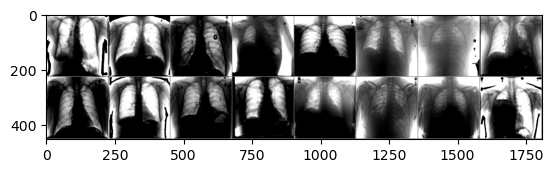

Labels: 0 0 1 1 1 0 0 1 0 0 0 0 0 1 1 0


In [10]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Display images using matplotlib
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Show a grid of images
imshow(torchvision.utils.make_grid(images))
print('Labels:', ' '.join(f'{label}' for label in labels))   

In [11]:
class CNN(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=in_channels,out_channels= 16, kernel_size=3, padding=1)
        self.acti1 = nn.ReLU()
        self.norm1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.acti2 = nn.ReLU()

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.acti3 = nn.ReLU()
        self.norm2 = nn.BatchNorm2d(64)

        self.gap = nn.AdaptiveAvgPool2d((1,1))
        self.fc1 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.pool(self.norm1(self.acti1(self.conv1(x))))
        x = self.pool(self.acti2(self.conv2(x)))
        x = self.pool(self.norm2(self.acti3(self.conv3(x))))

        x = self.gap(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        
        return x

In [12]:
model = CNN(in_channels=1, num_classes=2).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
num_epochs = 51
best_val_loss = float('inf')
patience = 5
counter = 0

for epoch in range(num_epochs):
    # -------- Training --------
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    train_loss /= len(train_loader)

    # -------- Validation --------
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = 100 * val_correct / val_total

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

    # -------- Early Stopping + Saving --------
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), "best_model.pth")
        print("✓ Model saved (val loss improved)")
    else:
        counter += 1
        print(f"No improvement for {counter} epochs")

        if counter >= patience:
            print("Early stopping triggered.")
            break


Epoch [1/51] Train Loss: 0.5035 | Train Acc: 75.19% Val Loss: 0.4687 | Val Acc: 77.19%
✓ Model saved (val loss improved)
Epoch [2/51] Train Loss: 0.4681 | Train Acc: 77.46% Val Loss: 0.4449 | Val Acc: 78.40%
✓ Model saved (val loss improved)
Epoch [3/51] Train Loss: 0.4515 | Train Acc: 78.48% Val Loss: 0.4434 | Val Acc: 78.75%
✓ Model saved (val loss improved)
Epoch [4/51] Train Loss: 0.4434 | Train Acc: 79.04% Val Loss: 0.4598 | Val Acc: 77.42%
No improvement for 1 epochs
Epoch [5/51] Train Loss: 0.4382 | Train Acc: 79.33% Val Loss: 0.4225 | Val Acc: 79.61%
✓ Model saved (val loss improved)
Epoch [6/51] Train Loss: 0.4306 | Train Acc: 79.84% Val Loss: 0.4199 | Val Acc: 80.47%
✓ Model saved (val loss improved)
Epoch [7/51] Train Loss: 0.4264 | Train Acc: 79.94% Val Loss: 0.4166 | Val Acc: 80.70%
✓ Model saved (val loss improved)
Epoch [8/51] Train Loss: 0.4206 | Train Acc: 80.24% Val Loss: 0.4927 | Val Acc: 77.24%
No improvement for 1 epochs
Epoch [9/51] Train Loss: 0.4201 | Train Acc: